## Word count analysis over time

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt
import sys
from pathlib import Path
import pandas as pd
import os
from scipy.stats import pearsonr, spearmanr


module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from util import CHAPTERS_DATA_TSV

In [38]:
def count_words(s: str):
    return len(s.split())

In [39]:
def words_per_second(row: pd.Series) -> float | None:
    n_words = row["word_count"]
    duration_s = row["duration_sec"]

    if pd.notna(duration_s) or pd.notna(n_words):
        return n_words / duration_s
    else:
        return None


def get_duration_sec(row: pd.Series) -> float | None:
    start_ms = row["start"]
    end_ms = row["end"]

    if pd.notna(start_ms) or pd.notna(end_ms):
        duration_sec = (float(end_ms) - float(start_ms)) / 1000
        return duration_sec
    else:
        return None

In [40]:
# Load chapters
tsv_file = Path(CHAPTERS_DATA_TSV).resolve()
df = pd.read_csv(tsv_file, sep="\t")

# Only data with timestamps
df = df[(df["start"].notna()) & (df["end"].notna())]

In [41]:
DF_COMBAT = df[(df["is_combat_scene"].notna()) & (df["is_combat_scene"])]
DF_WAR_REPORT = df[(df["is_war_report"].notna()) & (df["is_war_report"])]
DF_SOLDIERS = df[(df["german_soldiers_depicted"].notna()) & (df["german_soldiers_depicted"])]

/tmp/ipykernel_17458/1091624069.py:3: Pandas4Warning: 'and' operations between boolean dtype and str are deprecated and will raise in a future version. Explicitly cast the strings to a boolean dtype before operating instead.
  DF_SOLDIERS = df[(df["german_soldiers_depicted"].notna()) & (df["german_soldiers_depicted"])]


In [47]:
df_description = "Chapters flagged as combat scenes"
df = DF_COMBAT

print(f"Data size: {len(df)}")

df["word_count"] = df["audio_transcription"].apply(count_words)
df["duration_sec"] = df.apply(lambda row: get_duration_sec(row), axis=1)
df["word_count_per_second"] = df.apply(lambda row: words_per_second(row), axis=1)

Data size: 875


In [43]:
df["word_count_per_minute"] = df["word_count_per_second"]*60
df["word_count_per_minute"].describe()

count    875.000000
mean      56.001310
std       29.090385
min        7.304348
25%       36.699754
50%       48.095238
75%       67.012987
max      205.714286
Name: word_count_per_minute, dtype: float64

In [44]:
x = df['episode']
y = df['word_count_per_minute']

pearson_r, pearson_p = pearsonr(x, y)
spearman_r, spearman_p = spearmanr(x, y)
mean = df["word_count_per_minute"].mean()
median = df["word_count_per_minute"].median()
std = df["word_count_per_minute"].std()
print(f"Median: {median:.2f}")
print(f"Mean: {mean:.2f}")
print(f"Standard deviation: {std:.2f}")
print(f"Pearson:\tr = {pearson_r}\tp={pearson_p}")
print(f"Spearman:\tr = {spearman_r}\tp={spearman_p}")


Median: 48.10
Mean: 56.00
Standard deviation: 29.09
Pearson:	r = 0.29021512778771663	p=1.923936850162554e-18
Spearman:	r = 0.3016272419260197	p=7.320295368369785e-20


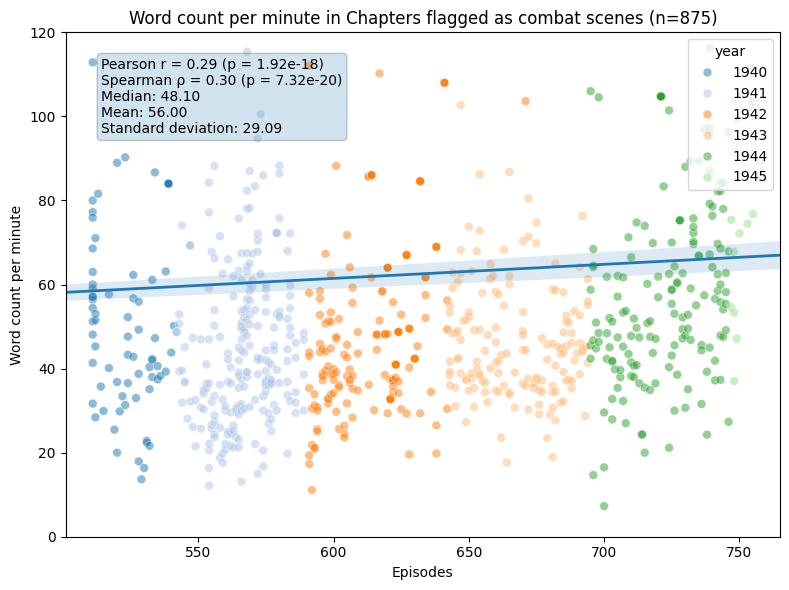

In [61]:
df_sorted = df.sort_values(["episode", "chapter"]).reset_index(drop=True)

text = (
    f"Pearson r = {pearson_r:.2f} (p = {pearson_p:.3g})\n"
    f"Spearman ρ = {spearman_r:.2f} (p = {spearman_p:.3g})\n"
    f"Median: {median:.2f}\n"
    f"Mean: {mean:.2f}\n"
    f"Standard deviation: {std:.2f}"
)

plt.figure(figsize=(8, 6))

ax = sns.scatterplot(
    data=df_sorted,
    x="episode",
    y="word_count_per_minute",
    hue="year",
    alpha=0.5,
    palette="tab20",
    legend="auto",
    s=40,
)

ax = sns.regplot(
    x=df_sorted.index,
    y=df_sorted["word_count_per_minute"],
    scatter=False,
    line_kws={"linewidth": 2},
)

plt.text(
    0.05,
    0.95,
    text,
    transform=plt.gca().transAxes,
    verticalalignment="top",
    bbox=dict(boxstyle="round", alpha=0.2),
)

plt.xlim(min(df["episode"]) - 10, max(df["episode"]) + 10)
plt.ylim(0, 120)
plt.xlabel("Episodes")
plt.ylabel("Word count per minute")
plt.title(f"Word count per minute in {df_description} (n={len(df_sorted)})")
sns.move_legend(ax, "upper right",bbox_to_anchor=(1, 1))

plt.tight_layout()
plt.show()